# T018 · Performance of ligand-based machine learning methods for the classification of active/inactive compounds, considering various validation approaches

Supervisior:

* JProf. Dr. Andrea Volkamer; AG Volkamer:  Institut für Physiologie - Charité Universitätsmedizin


Author:

* Hee-yeong Kim; WiSe20/21; Freie Universität Berlin; Bioinformatik (M.Sc.)

## Aim of this project work
Currently, the application and evaluation of Machine Learning (ML) based approaches, especially in the field of CADD is still state-of-art (see [Mathai, Neann *et al.*, <i>IJMS</i> (2020), <b>21.10</b>, 3585](https://www.mdpi.com/1422-0067/21/10/3585), [Wang, Chen *et al.*, <i>Briefings in bioinformatics</i> (2019), <b>20.06</b>, 2066-2087](https://academic.oup.com/bib/article-abstract/20/6/2066/5066711), [Mathai, Neann *et al.*, <i>Briefings in bioinformatics</i> (2019), <b>21.3</b>,791-802](https://academic.oup.com/bib/article/21/3/791/5428023)).

* Search for appropriate strategies for QSAR models applied on chemical compounds.
* Assess the performance and predictive power of ML-methods.
* Splitting schemes: cluster-based split approaches (see [Stahl, Martin *et al.*, <i>J. Chem. Inf. Model.</i> (2005), <b>45.3</b>, 542-548](https://pubs.acs.org/doi/abs/10.1021/ci050011h), [Martin, Eric J. *et al.*, <i>J. Chem. Inf. Model</i> (2017), <b>57.8</b>, 2077-2088](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00166), [Leonard, J. *et al.*, <i>QSAR and Combinatorial Science</i> (2006), <b>25.3</b>, 235-251](https://onlinelibrary.wiley.com/doi/abs/10.1002/qsar.200510161), [Stanforth, Robert W. *et al.*, <i>QSAR and Combinatorial Science</i> (2007), <b>26.7</b>, 837-844](https://onlinelibrary.wiley.com/doi/abs/10.1002/qsar.200630086), [He, Linnan *et al.*, <i>J. Mol. Graph</i> (2005), <b>23.6</b>, 503-523](https://www.sciencedirect.com/science/article/abs/pii/S1093326305000173)) and cross validation (CV) by random and time-split (see [Sheridan, Robert P., <i>J. Chem. Inf. Model</i> (2013), <b>53.4</b>, 783-790](https://pubs.acs.org/doi/abs/10.1021/ci400084k)).
* Compare the different splitting methods and observe the performance of the models based on some performance metrics.

![Workflow](images/workflow.png)
*Figure 1:* 
Workflow of this notebook. It can be mainly partitioned into data creation (left) and methods (right). The methods comprise the different model evaluation approaches and performance metrics.

## Theory

### Biological Background
#### Epidermal growth factor receptor (EGFR)
* Transmembrane glycoprotein is located at the cell surface and binds to the epidermal growth factor.
* Activated by binding to a ligand, which induces cell proliferation and prevents the apoptotic cell death. 
* Mutations are associated with a number of cancers (non-small cell lung cancer (NSCLC) (40-80%), glioblastoma, head and neck cancer as well as breast cancer (25-30%), see [Herbst, Roy S., <i>IJROBP</i> (2004), <b>43</b>, S21-S26](https://www.sciencedirect.com/science/article/pii/S0360301604003311).
* Importance of its investigation for research and therapeutic issues.

Computer-Aided Drug Design (CADD) uses computational approaches to discover, enhance, develop and analyze drugs and similar biologically active molecules. It can be described by three major approaches: ligand-based, structure-based and system-based drug discovery methods.

* Ligand-based approach: Structural similar molecules have similar properties and thus similar biological activity.
* Prediction of active and inactive compounds (activation or inhibition of the target protein).

### Data Acquisition and preparation
For the data acquisition and filtering step, the preimplemented talktorials, [001_query_chembl](https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html) and [002_compound_adme](https://projects.volkamerlab.org/teachopencadd/talktorials/T002_compound_adme.html), provided by the research group of [Volkamer Lab](https://projects.volkamerlab.org/teachopencadd/) were used. Talktorial [007_compound_activity_machine_learning](https://projects.volkamerlab.org/teachopencadd/talktorials/T007_compound_activity_machine_learning.html) is used as framework of this notebook and functions for Butina Clustering are taken from [005_compound_clustering](https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html).

1. Choose the target data (EGFR Kinase: P00533) and fetch and download the bioactivity information and the compounds (ChEMBL ID, SMILES) from ChEMBL data base.

Add "document_year" in the function from 001_query_cembl to fetch the publishing year of the compounds along with bioactivity data from ChEMBL:

bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B").only(
    
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
    "document_year"
)


2. Filter the compounds according to Lipinski's Rule of Five, to estimate the bioavailability of compounds solely based on their chemical structure.
3. Selected compounds as candidates for further investigation, if not more than one rule was violated.

The final composed EGFR data set comprises following parameters for each compound:

* CHEMBL-ID
* Publishing year
* SMILES representation (Simplified Molecular Input Line Entry Specification)
* pIC50 value: -log10(IC50), with IC50 = Concentration of a drug to inhibit a process by 50% (in vitro).
* Molecular weight
* Number of hydrogen bond acceptors (HBAs)
* Number of hydrogen bond donors (HBDs)
* log(p) (octanol-water coefficient): Used as measure of hydrophobicity.



#### Molecule encoding
It is a crucial step in CADD to encode the molecules to an abstract and interpretable representation for the computer while keeping important information of certain structural properties. Usually, molecular fingerprints are used to describe small molecules and are represented by bit vectors, where each fingerprint bit corresponds to a fragment of the molecule.


![fingerprint vector](images/fp_.png)
*Figure 2:* 
Examplary visualization of a molecular fingerprint as bit vector: each bit corresponds to a fragment of the molecules, encoded with 1 for its presence, otherwise 0. The figure is taken from: [ChemAxon](https://chemaxon.com/news/chemaxon-us-user-group-meeting-ugm-san-diego-september-24-25-2013).

RDKit provides various functions generating [molecular fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity). The method section here is done with MACCS only, a comparision of the ML-methods between MACCS and Morgan is withdrawable from 007.

* **MACCS keys**: 166 bit structure fingerprints, where each bit corresponds to a predefined structural feature (substructure or fragment). 
* **Morgan fingerprints or Extended-Connectivity Fingerprints (ECFPs)**: Circular topological fingerprints, generated by considering the “circular” environment of each atom up to a given radius or diameter (see [here](https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics_OLCC_(2019)/6%3A_Molecular_Similarity/6.1%3A_Molecular_Descriptors) for a general overview of molecular descriptor types).

### Machine Learning (ML) Approaches

In Machine Learning, supervised learning describes methods to learn the mapping function from the input to the output. The goal is to approximate the mapping function good enough, to predict for new input data the output variables with a specific accuracy.

The here introduced ML-appraoches are commonly used in drug discovery, consisting of:

* **Random Forest (RF)**: Classification method that randomly builds an ensemble of uncorrelated decision trees, aims to minimize the entropy in each split and predicts on the majority or mean occurance of a class. 

* **Support Vector Machine (SVM)**: A mathematical method to find a hyperplane in an n-dimensional space (n=#features) to separate data points with maximum margin, i.e the maximum distance between data points of both classes. Nonlinearly separable samples are projected onto another higher dimensional space by using different types of kernel functions.

### Data Splitting Schemes
The use of Machine Learning methods to overcome financial restrictions, limited sources or more sophisticated problems in medicine and economy, increased over the last decades. Therefore more advanced techniques were developed with high performance, like CNNs but still represent an incomprehensible black box in their decision making process. This brought up the need for approaches to infer the performance of the models and assess their reliability and 'realistic' predictive power on new data.

#### Role of Train/Test and Validation Set in ML
The data we want to predict on is usually divided in three parts:

* Training Set: Train the model by fitting on the data.

* Validation Set: Validation of the performance of the models is tested and used to adjust the model hyperparameters (e.g. number of layers in an NN).

* Test Set: Evaluate the performance on unlabeled data to assess their true performance. Usually used to compare models.

In our case, the role of validation and test sets are identical, since this project does not aim to compare the models itself but assess their performance depending on the data splitting scheme.

#### Random Splitting Schemes
* **Single random Split**: As the name already implies, it splits the data into train and test set by a given percentage. Usually, a split of 80% for train and 20% for test is applied.

* **k-fold Cross Validation (CV)**: The data is partitioned into k folds. In each of the k partitions, k-1 parts are used as training set, while the remaining k-th part serves as test set.

![k-fold Cross Validation](images/cv.png)
*Figure 3:* 
Example of internal data splitting for 5-fold Cross Validation. The figure is taken from: [Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)

#### Time-based Splitting
* Type of Cross Validation to deal with time-related data (data is sorted by time in ascending order).
* Splits train/test sets in a 'sliding window' approach.
* In each split, the test indices must be higher than before.
* Simulating the process of prospective validation (see [Sheridan, Robert P., <i>J. Chem. Inf. Model</i> (2013), <b>53.4</b>, 783-790](https://pubs.acs.org/doi/abs/10.1021/ci400084k)).

![time-split Cross Validation](images/timesplit_cv.png)
*Figure 3:* 
Time based Cross Validation approach. The test set in each fold is colored in orange. The figure is taken from: [towardsdatascience](https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8)

Scikit-learn has a [TimeSeriesSplit](https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) method with the main drawback, that the splitting process is not interferable. Therefore two functions are implemented in this notebook, a naive (recommended) implementation and another version, where the splits are infered such that the train and test sets are disjoint w.r.t. the year.

#### Cluster-based Splitting

General idea is to use an algorithm to cluster the compounds based on their sturctural features to get: 
* Train set: Largest clusters are used to cover a wide chemical space.
* Test set: Small remaining clusters and/or singletons are used to provide a 'realistic' model evaluation with unseen, structural diverse molecules.

**Algorithms**:

1. **Butina Clustering** [butina1999]: Clustering technique based on fingerprints and Tanimoto similarity.

![Butina clustering algorithm](images/butina.png)
*Figure 4:* 
Schematic overview of the Butina clustering algorithm. The illustrations are taken from talktorial 005 of the Volkamer lab: [005_compound_clustering](https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html)

2. **K-means**: Is a very common clustering technique, that aims to partition n observations into k clusters, where each observation belongs to the cluster with the smallest (euclidian) distance.

![K-means clustering algorithm](images/kmeans.png)
*Figure 5:* 
Demonstration of the K-means algorithm for three centroids (circles) and some samples (squares). The figure is taken from: [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)

### Performance metrics

**Accuracy**: ACC = (TP + TN)/(TP + TN + FP + FN)
* _Informal:_ The fraction of predictions the model got right. The number of correct predictions divided by the total number of predictions.

**Sensitivity**: TruePositiveRate = TP/(FN + TP)
*  _Informal:_ Measures the proportion of true positives that are correctly identified

**Specificity**: TrueNegativeRate = TN/(FP + TN)
*  _Informal:_ Measures the proportion of true negatives

**Area under the ROC curve (AUC)**: AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

**Receiver operating characteristic (ROC) Curve Plot**: is a graph showing the performance of a classification model at all classification thresholds.

This curve plots two parameters:
* True Positive Rate (y-axis)
* False Positive Rate (x-axis)

### References

* Similarity-Based Methods and Machine Learning Approaches for Target Prediction in Early Drug Discovery: Performance and Scope: [Mathai, Neann *et al.*, <i>IJMS</i> (2020), <b>21.10</b>, 3585](https://www.mdpi.com/1422-0067/21/10/3585)
* Review and comparative assessment of similarity-based methods for prediction of drug–protein interactions in the druggable human proteome: [Wang, Chen *et al.*, <i>Briefings in bioinformatics</i> (2019), <b>20.06</b>, 2066-2087](https://academic.oup.com/bib/article-abstract/20/6/2066/5066711)
* Validation strategies for target prediction methods: [Mathai, Neann *et al.*, <i>Briefings in bioinformatics</i> (2019), <b>21.3</b>,791-802](https://academic.oup.com/bib/article/21/3/791/5428023)
* Database clustering with a combination of fingerprint and maximum common substructure methods: [Stahl, Martin *et al.*, <i>J. Chem. Inf. Model.</i> (2005), <b>45.3</b>, 542-548](https://pubs.acs.org/doi/abs/10.1021/ci050011h)
* Profile-QSAR 2.0: kinase virtual screening accuracy comparable to four-concentration IC50s for realistically novel compounds: [Martin, Eric J. *et al.*, <i>J. Chem. Inf. Model</i> (2017), <b>57.8</b>, 2077-2088](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00166)
* On selection of training and test sets for the development of predictive QSAR models: [Leonard, J. *et al.*, <i>QSAR and Combinatorial Science</i> (2006), <b>25.3</b>, 235-251](https://onlinelibrary.wiley.com/doi/abs/10.1002/qsar.200510161)
* A measure of domain of applicability for QSAR modelling based on intelligent K‐means clustering: [Stanforth, Robert W. *et al.*, <i>QSAR and Combinatorial Science</i> (2007), <b>26.7</b>, 837-844](https://onlinelibrary.wiley.com/doi/abs/10.1002/qsar.200630086)
* Assessing the reliability of a QSAR model's predictions: [He, Linnan *et al.*, <i>J. Mol. Graph</i> (2005), <b>23.6</b>, 503-523](https://www.sciencedirect.com/science/article/abs/pii/S1093326305000173)
* Time-split cross-validation as a method for estimating the goodness of prospective prediction: [Sheridan, Robert P., <i>J. Chem. Inf. Model</i> (2013), <b>53.4</b>, 783-790](https://pubs.acs.org/doi/abs/10.1021/ci400084k)
* Review of epidermal growth factor receptor biology: [Herbst, Roy S., <i>IJROBP</i> (2004), <b>59.2</b>, S21-S26](https://www.sciencedirect.com/science/article/pii/S0360301604003311)

## Practice and Results

In [1]:
import pandas as pd
import numpy as np
#Molecule Encoding
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
#ML-approaches
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
#CV and Random Division
from sklearn.model_selection import KFold, train_test_split, cross_validate
#Time-split CV
from sklearn.model_selection import TimeSeriesSplit
#Cluster-based splits
import math
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.cluster import KMeans
import kneed
from kneed import KneeLocator #find appropriate number of cluster centers for kmeans
#Performance Metrics
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
#Plotting
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
#Display Images
from IPython.display import Image

In [2]:
#global parameter(s)
SEED = 22 #fixed seed for reproducible results
N_FOLDS = 10 #for random- and time-split CV
cut_off = 0.1 #for similarity-based clustering

### 1. Load compound data

In [3]:
path_to_data = 'data/EGFR_compounds_lipinski_timeseries.csv'
chembl_df = pd.read_csv(path_to_data, index_col=0)

print("Number of molecules : ", chembl_df.shape[0])
print("Number of features : ", chembl_df.shape[1])

Number of molecules :  4493
Number of features :  11


In [4]:
# Keep only the columns we want
chembl_df = chembl_df.drop(columns=["IC50","units","ro5_fulfilled"])
#convert document_year to int
chembl_df["document_year"] = chembl_df["document_year"].astype(int)
chembl_df.head()

molecule_chembl_id  document_year                               smiles  \
0        CHEMBL63786           1996    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1   
1        CHEMBL53711           1998   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1   
2        CHEMBL35820           1997  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC   
3        CHEMBL66031           1999  Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1   
4        CHEMBL53753           1999      CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1   

       pIC50  molecular_weight  n_hba  n_hbd    logp  
0  11.522879        349.021459      3      1  5.2891  
1  11.221849        343.043258      5      1  3.5969  
2  11.221849        387.058239      5      1  4.9333  
3  11.096910        339.011957      4      2  4.0122  
4  11.096910        329.027607      5      2  3.5726

### 2. Data preparation

#### Data labeling
Classify each compound as active or inactive based on the pIC50 value.

A common cut-off value to discretize pIC50 data is 6.3, which is also used here.
Note that there are several other suggestions for an activity cut-off ranging from an pIC50 value of 5 to 7 in the literature. 

In [5]:
# Add column for activity
chembl_df["activity"] = np.zeros(len(chembl_df))

# Assign binary activity score (activity = 1)
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "activity"] = 1.0

print("Number of active compounds:", int(chembl_df.activity.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.activity.sum()))
chembl_df.head()

Number of active compounds: 2555
Number of inactive compounds: 1938


molecule_chembl_id  document_year                               smiles  \
0        CHEMBL63786           1996    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1   
1        CHEMBL53711           1998   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1   
2        CHEMBL35820           1997  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC   
3        CHEMBL66031           1999  Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1   
4        CHEMBL53753           1999      CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1   

       pIC50  molecular_weight  n_hba  n_hbd    logp  activity  
0  11.522879        349.021459      3      1  5.2891       1.0  
1  11.221849        343.043258      5      1  3.5969       1.0  
2  11.221849        387.058239      5      1  4.9333       1.0  
3  11.096910        339.011957      4      2  4.0122       1.0  
4  11.096910        329.027607      5      2  3.5726       1.0

#### Molecule encoding

In [6]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """
    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
    if method == "morgan2":
        return GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    if method == "morgan3":
        return GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits)
    else: #default maccs
        return MACCSkeys.GenMACCSKeys(mol)

In [7]:
compound_df = chembl_df.copy()

In [8]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)

#Command to calc. another fp type
#compound_df["fp_morgan2"] = compound_df["smiles"].apply(smiles_to_fp, args=('morgan2',))

molecule_chembl_id  document_year                               smiles  \
0        CHEMBL63786           1996    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1   
1        CHEMBL53711           1998   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1   
2        CHEMBL35820           1997  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC   

       pIC50  molecular_weight  n_hba  n_hbd    logp  activity  \
0  11.522879        349.021459      3      1  5.2891       1.0   
1  11.221849        343.043258      5      1  3.5969       1.0   
2  11.221849        387.058239      5      1  4.9333       1.0   

                                                  fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

### 3. Methods

#### 3.1 Machine Learning (ML) Models

In [9]:
#Set model parameter
param = {
    "n_estimators": 100,  # number of trees
    "criterion": "entropy",  # cost function
}
model_RF = RandomForestClassifier(**param)
models = [{"label": "Model_RF", "model": model_RF}]

model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
models.append({"label": "Model_SVM", "model": model_SVM})

#### 3.2 Model evaluation

In [10]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [11]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """
    
    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig("roc_auc_"+str(ml_model), dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [12]:
def plot_roc_curves_for_singlemodel(models, test_x, test_y, model_type, title_, save_png=False):
    fig, ax = plt.subplots()
    
    for i in range(len(test_x)):
        # Prediction probability on test set
        test_prob = models[i].predict_proba(test_x[i])[:, 1]
        # Prediction class on test set
        test_pred = models[i].predict(test_x[i])
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y[i], test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y[i], test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model_type[i]}: AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title_)
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig("roc_auc_"+str(ml_model), dpi=300, bbox_inches="tight", transparent=True)
    return fig

#### Random Split

In [13]:
def random_split(X_set, Y_set, testsize):
    x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=testsize, shuffle=True, random_state=SEED)
    return x_train, x_test, y_train, y_test

#### k-Fold Cross Validation

[KFold()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)_ will randomly pick the datapoints which would become part of the train and test set. Not completely randomly, if random_state is set to an integer value. It influences which points appear in each set and the same random_state always results in the same split.

In [14]:
def cross_validation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with fingerprints and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    List of lists:
        accuracy, sensitivity, speicificty, auc for each fold.

    """
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].activity.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].activity.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

#### Naive Time-split cross validation 

Provides train/test indices to split time series data samples that are observed at fixed time intervals. In each split, test indices must be higher than before, and thus shuffling is inappropriate.

In [15]:
def naive_timesplit_CV(ml_model, df, n_folds=5, get_sets=False, verbose=False):
    """
    Machine learning model training and validation in a time-split cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with fingerprints and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    get_sets: bool, optional
        Returns
        -------
        List of lists:
            train and test sets used to perform time-split CV.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    List of lists:
        accuracy, sensitivity, specificity, auc for each fold.

    """
    tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_folds)
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = [] 
    plot_train = []
    plot_test = []
    for train_index, test_index in tscv.split(df):
        #print("TRAIN:", train_index, "TEST:", test_index)
        time_model = clone(ml_model)
        
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].activity.tolist()
        
        plot_train.append(df.iloc[train_index])
        
        # Train the model
        time_model.fit(train_x, train_y)
       
        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].activity.tolist()
        
        plot_test.append(df.iloc[test_index])
        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(time_model, test_x, test_y, verbose)

        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    if get_sets:
        return plot_train, plot_test
    else: 
        # Print statistics of results
        print(
            f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
            f"and std : {np.std(acc_per_fold):.2f} \n"
            f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
            f"and std : {np.std(sens_per_fold):.2f} \n"
            f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
            f"and std : {np.std(spec_per_fold):.2f} \n"
            f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
            f"and std : {np.std(auc_per_fold):.2f} \n"
        )
        return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

#### Modified Time-split cross validation 

Train/test indices are splitted such that the fixed time intervals are distinct in both sets to guarentee that in each split, test indices are higher than the train indices.

In [16]:
def timesplit_CV(ml_model, df, n_folds=5, get_sets=False, verbose=False):
    """
    Machine learning model training and validation in a time-splot cross-validation loop for distinct years in both sets.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with fingerprints and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    get_sets: bool, optional
        Returns
        -------
        List of lists:
            train and test sets used to perform time-split CV.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    List of lists:
        accuracy, sensitivity, speicificty, auc for each fold.

    """
    tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_folds)
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = [] 
    plot_train = []
    plot_test = []
    for train_index, test_index in tscv.split(df):
        #print("TRAIN:", train_index, "TEST:", test_index)
        time_model = clone(ml_model)        
        #split sets at years
        left_interval = df.iloc[train_index].document_year.tolist()
        right_interval = df.iloc[test_index].document_year.tolist()
        if list(set(left_interval)&set(right_interval)) != []: #if intersection not empty
            inters=[]
            intersection = list(set(left_interval)&set(right_interval))
            #get molecule index by intersection (document year)
            l =df.loc[train_index].document_year[df.loc[train_index].document_year == intersection[0]].count()
            r =df.loc[test_index].document_year[df.loc[test_index].document_year == intersection[0]].count()
            inter = df.document_year[df.document_year == intersection[0]].index.tolist()
            #molecules are continuously numbered, therefore get them by considering the first and last numbers
            pos = np.where(df.index==inter[0])[0]
            pos_n = np.where(df.index==inter[-1:])[0]
            #fill the numbers inbetween
            inters.extend(range(pos[0],pos_n[0]+1))
            #assign compounds belonging to the year to the largest set
            if l >= r:
                #delete compounds corresponding to the considered year
                train_index = [i for i in train_index if i not in inters]
                #add all compounds (indices) corresponding to the year to the training set
                train_index = np.append(inters, train_index)
                #remove intersecting molecule indices in training set from test set
                test_index = [j for j in test_index if j not in train_index]
            else:
                #delete compounds corresponding to the considered year
                test_index = [k for k in test_index if k not in inters]
                #add all compounds (indices) corresponding to the year to the test set
                test_index = np.append(inters, test_index)
                #remove intersecting molecule indices in test set from training set
                train_index = [l for l in train_index if l not in test_index]
            
        else: pass
        
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].activity.tolist()
        
        plot_train.append(df.iloc[train_index])
        # Train the model
        time_model.fit(train_x, train_y)
       
        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].activity.tolist()
        
        plot_test.append(df.iloc[test_index])
        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(time_model, test_x, test_y, verbose)

        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    if get_sets:
        return plot_train, plot_test
    else: 
        # Print statistics of results
        print(
            f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
            f"and std : {np.std(acc_per_fold):.2f} \n"
            f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
            f"and std : {np.std(sens_per_fold):.2f} \n"
            f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
            f"and std : {np.std(spec_per_fold):.2f} \n"
            f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
            f"and std : {np.std(auc_per_fold):.2f} \n"
        )
        return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

#### Plot the data splitting of train and test sets and plot the accuracy per fold for cross validation methods. 
To get the respective sets, set get_sets parameter to True (default=False).

In [17]:
def plot_cv_data(train_timeset, test_timeset, nfolds, title_):
    """
    Plots train and test sets used for time-split cross validation in a histogram: sample sizes over years.

    Parameters
    ----------
    train_timeset: pd.Dataframe
        Data set sorted by year (ascending order) with document year and Id for each molecule.
    train_timeset: pd.Dataframe
        Data set sorted by year (ascending order) with document year and Id for each molecule. 
    n_folds: int, optional
        Number of folds for cross-validation.
    title_: string
        Set title of plot

    Returns
    -------
    plot:
        Displays subfigures, one for each fold in the cross validation.

    """
    df_list=[]
    for i in range(len(train_timeset)):
        df_years = []
        #group the molecules by years in ascending order and count the members
        years = train_timeset[i].groupby(train_timeset[i]["document_year"]).count()
        years_test = test_timeset[i].groupby(test_timeset[i]["document_year"]).count()
        df_years = pd.DataFrame(years.molecule_chembl_id.tolist(), index = years.index.tolist(), columns=['train'])
        #add a new colum to the dataframe initilized with zeros
        df_years['test'] = 0
        for ind in years_test.index.tolist():
            #put the number of members to the respective year (position)
            df_years.at[ind, 'test'] = years_test.loc[ind, :][0]
        df_list.append(df_years)
    #plot the distribution of training and test samples
    #nrow = math.ceil(len(train_timeset)/nfolds)
    ncol=nfolds
    print(title_)
    fig, axes = plt.subplots(1, ncol, figsize=(18,5))
    for i in range(len(train_timeset)):
        df_list[i].plot(kind='bar', ax=axes[i], title=str(i+1)+'-fold')
    return plt.show()

In [18]:
def plot_cv_accuracy(acc_list, model_list, title_):
    """
    Plots accuracy of cross validation at each fold.

    Parameters
    ----------
    acc_list: list of lists
        Each list contains the accuracy per fold for the respective model type i (i-th entry in model_list)
    model_list: list of strings
        Each string specifies the used model and evaluation method (random CV, time-split CV).
        Displayed as legend in the plots.
    title_: string
        Set title of plot

    Returns
    -------
    plot:
        Plots accuracy of each model per fold.

    """
    df_acc = pd.DataFrame(acc_list).T
    #assign the model and evaluation method
    df_acc.columns = model_list
    n_models = int(len(model_list)/3)
    nrow=math.ceil(n_models/3)
    print(title_)
    fig, axes = plt.subplots(nrow, n_models, figsize=(18,5))
    #plot the accuracy for all evaluation methods belonging to a model
    for i in range(n_models):
        ax = df_acc.iloc[:, i::n_models].plot(style='o-', ax=axes[i], title=models_method[i][:-10])
        ax.set(xlabel='n-folds', ylabel='accuracy')
    return plt.show()

**Cluster-based Split**

**1) Butina Clustering**

* Convert SMILES to Fingerprints (maccs)
* Calculate Tanimoto dissimilarity matrix (1-similarity)
* Cluster the molecules based on exclusion spheres using RDKit _Butina.ClusterData()_.
* Assign the compound from the clusters to train and test set with an ratio approximately 80:20.


In [19]:
def Tanimoto_distance_matrix(df_fps):
    """
    Calculate the pairwise Tanimoto distance (1-similarity) of the compounds.

    Parameters
    ----------
    df_fps: list of lists
        A list containing the fingerprint representation of each molecule as list.

    Returns
    -------
    List of lists:
        Distance matrix.

    """
    dissimilarity_matrix = []
    # Notice we are skipping the first and last items in the list because we don't need to compare them against themselves
    for i in range(1, len(df_fps)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(df_fps[i], df_fps[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [20]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """
    Cluster fingerprints by a given cut-off value with Butina Clustering technique and 
    the corresponding Tanimoto similarity based distance matrix.

    Parameters
    ----------
    figerprints: list of lists
        Each sublist contains the pairwise distance from one to all other molecules.
        Distance is defined by 1-Tanimoto Similarity.
        Output of the function Tanimoto_distance_matrix().

    Returns
    -------
    List of tuples:
        Each tuple represents a cluster and contains the molecule IDs belonging to it.

    """
    # Calculate Tanimoto distance matrix
    distance_matrix = Tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    num_singletons = sum(1 for c in clusters if len(c) == 1)
    largest_clust = len(clusters[0])
    print('Size of largest cluster: ', largest_clust)
    print('Number of Singletons: ', num_singletons)
    return clusters

In [21]:
def fingerprint_split(df_compounds, cluster_set):
    """
    Splits the clusters into train and test set by assigning at least all singletons to the test set.

    Parameters
    ----------
    df_compounds: pd.Dataframe
        Data set with fingerprints and their associated activity labels.
    cluster_set: List of  tuples
        Each tuple represents the membership of the molecules.
        Output of the function cluster_fingerprints().

    Returns
    -------
        Lists:
            train and test set with their activity label.

    """
    train_data=[]; train_label=[]; singletons=[]; s_label=[]
    for i in range(len(cluster_set)):
        if len(cluster_set[i]) <= 1: 
            singletons.append(df_compounds.fp[cluster_set[i][0]])
            s_label.append(df_compounds.activity[cluster_set[i][0]])
        else:
            train_data.append(df_compounds.fp.loc[list(cluster_set[i])].tolist())
            train_label.append(df_compounds.activity.loc[list(cluster_set[i])].tolist())
    return [x for xi in train_data for x in xi], [y for yi in train_label for y in yi], singletons, s_label

**2) K-means**


* Convert SMILES to a set of physicochemical properties (=200).
* Cluster the molecules based on the properties using Scikit-learn _KMeans()_ function.
* Choose an appropiate initial k (empirically or elbow method)
* Assign the compound from the clusters to train and test set with ratio approximately 80:20.

In [22]:
def elbow_method(features_list, show_image=False):
    """
    Selects an appropriate number of cluster centers for kmeans using KneeLocator().

    Parameters
    ----------
    features_list: np.array
        Contains features of each molecule.
    show_image: bool, optional
        Shows image with knee point.
        
    Returns
    -------
        Int:
            Optimal number of cluster centers.

    """
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(features_list)
        sse.append(kmeans.inertia_)
    if show_image==True:
        plt.style.use("fivethirtyeight")
        plt.plot(range(1, 11), sse)
        plt.xticks(range(1, 11))
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")
        plt.show()
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    return kl.elbow

In [23]:
def cluster_features(df, number_of_centers, elbowmethod=False):
    """
    Cluster SMILES by their physicochemical properties with kemans.

    Parameters
    ----------
    df: pd.Dataframe
        Data set with SMILES and molecule IDs.
    number_of_centers: int, ignored if elbowmethod=True
        Define the number of cluster centers for kmeans.
    elbowmethod: bool, optional
        Uses elbow-method to determine the optimal number of cluster centers of the data.
        
    Returns
    -------
        List of lists:
            Each sublist belongs to a cluster and contains the corresponding molecule member IDs.

    """
    features=[x[0] for x in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(features)
    df['physchem'] = df['smiles'].apply(lambda sm: calc.CalcDescriptors(Chem.MolFromSmiles(sm)))
    p = df.physchem.tolist()
    physicochems =np.array([list(elem) for elem in p])
    physicochems = np.nan_to_num(physicochems)
    if elbowmethod:
        number_of_centers = elbow_method(physicochems, show_image=True)
        kmeans = KMeans(n_clusters=number_of_centers, random_state=0).fit(physicochems)
        print('Size of clusters: ', np.bincount(kmeans.labels_[kmeans.labels_>=0]))
    else:
        kmeans = KMeans(n_clusters=number_of_centers, random_state=0).fit(physicochems)
        print('Size of clusters: ', np.bincount(kmeans.labels_[kmeans.labels_>=0]))
    clus = kmeans.labels_
    df['cluster_member'] = clus
    members=[]
    for mem in np.unique(clus):
        members.append(df.cluster_member[df.cluster_member == mem].index.tolist())
    return members

#### Example for K-means clustering with elbow-method:

The algorithm finds the knee (or elbow) point of a curve. It is defined as the point of maximum curvature in a system. Identifying this location in a curve then can be used, to select an appropriate value of k in K-means clustering (see https://www.kaggle.com/kevinarvai/knee-elbow-point-detection).

The SSE values for each Cluster (sum of squared error or inertia) is calculated by k-means. The smaller the value becomes the denser the cluster points are.

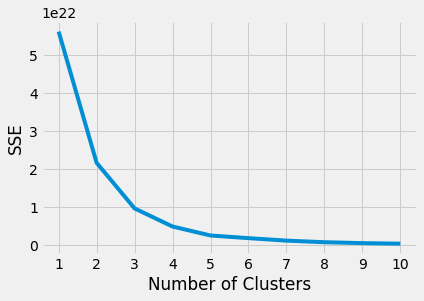

Size of clusters:  [4475   16    2]
#clusters for this data:  3


In [24]:
c = cluster_features(compound_df, 0, True)
print('#clusters for this data: ', len(c))


In [25]:
def feature_split(df, feature_list):
    """
    Splits the clusters into train and test set such that the training set is approximately 80%.

    Parameters
    ----------
    df: pd.Dataframe
        Data set with fingerprints and their associated activity labels.
    feature_list: list of lists
        Each sublist contains the features for a molecule.
        Output of function cluster_features().
        
    Returns
    -------
        Lists:
            train and test set with their activity label.

    """
    count=1
    cond = len(feature_list[0]) #set to the first cluster
    #if the train set is smaller than 80%
    while cond/len(df) <= 0.8:
        cond+=len(feature_list[count]) #append the next cluster
        count+=1
    train_ind = feature_list[:count]
    test_ind = feature_list[count:]
    train_index = [x for xi in train_ind for x in xi] #flat list of lists
    test_index = [y for yi in test_ind for y in yi] 
    xtrain = df.loc[train_index].fp.tolist() #get fingerprints from dataframe at respective indices
    ytrain = df.loc[train_index].activity.tolist() #get activity labels from dataframe at respective indices
    xtest = df.loc[test_index].fp.tolist()
    ytest = df.loc[test_index].activity.tolist()
    return xtrain, ytrain, xtest, ytest

### 4. Results
#### 4.1 Performace on random selected sets

In [26]:
#Divide the set into training and test set for random split
fingerprint_model = compound_df.fp.tolist()
label_model = compound_df.activity.tolist()
test_size=0.2
x_train, x_test, y_train, y_test = random_split(fingerprint_model, label_model, test_size)
print(f"Fit model on single split with train/test split of {round((100-test_size*100),2)}% to {round(test_size*100,2)}%")
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    model['model'].fit(x_train, y_train)
    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(model['model'], x_test, y_test, False)
    print('accuracy: ',accuracy)
    print('sensitivity: ', sens)
    print('specifity: ', spec)
    print('AUC score: ', auc)

Fit model on single split with train/test split of 80.0% to 20.0%

Model_RF
accuracy:  0.814238042269188
sensitivity:  0.8921568627450981
specifity:  0.712082262210797
AUC score:  0.8953223448762538

Model_SVM
accuracy:  0.8275862068965517
sensitivity:  0.9098039215686274
specifity:  0.7197943444730077
AUC score:  0.8846212006653561


In [27]:
print(f"{N_FOLDS}-fold Cross Validation performance: ")
models_acc=[] #store accuracy per fold 
models_method=[] #store model and evaluation method
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    acc,_,_,_ = cross_validation(model["model"],compound_df, n_folds=N_FOLDS)
    models_method.append((f"{model['label']}+random CV"))
    models_acc.append(acc)

10-fold Cross Validation performance: 

Model_RF
Mean accuracy: 0.83 	and std : 0.01 
Mean sensitivity: 0.88 	and std : 0.02 
Mean specificity: 0.77 	and std : 0.03 
Mean AUC: 0.90 	and std : 0.01 


Model_SVM
Mean accuracy: 0.85 	and std : 0.01 
Mean sensitivity: 0.90 	and std : 0.02 
Mean specificity: 0.77 	and std : 0.03 
Mean AUC: 0.90 	and std : 0.02 



#### 4.2 Performace on Time-split CV

In [28]:
#Sort the dataframe by document year in ascending order and reindex the row numbering into continuous numbers.
compounds_set_time = compound_df.sort_values(by=['document_year'])
compounds_set_time = compounds_set_time.reset_index(drop=True)

#### Naive Time-split CV

In [29]:
print(f"{N_FOLDS}-fold (naive) Time-Split Cross Validation performance: ")
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    acc,_,_,_ = naive_timesplit_CV(model["model"], compounds_set_time, n_folds=N_FOLDS)
    models_method.append(f"{model['label']}+Time-split CV (naive)")
    models_acc.append(acc)

10-fold (naive) Time-Split Cross Validation performance: 

Model_RF
Mean accuracy: 0.76 	and std : 0.04 
Mean sensitivity: 0.82 	and std : 0.04 
Mean specificity: 0.65 	and std : 0.11 
Mean AUC: 0.80 	and std : 0.05 


Model_SVM
Mean accuracy: 0.73 	and std : 0.08 
Mean sensitivity: 0.74 	and std : 0.10 
Mean specificity: 0.70 	and std : 0.12 
Mean AUC: 0.79 	and std : 0.05 



#### Time-split CV for fixed split points

In [30]:
print(f"{N_FOLDS}-fold Time-Split Cross Validation performance: ")
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    acc,_,_,_ = timesplit_CV(model["model"], compounds_set_time, n_folds=N_FOLDS)
    models_method.append(f"{model['label']}+Time-split CV")
    models_acc.append(acc)

10-fold Time-Split Cross Validation performance: 

Model_RF
Mean accuracy: 0.71 	and std : 0.04 
Mean sensitivity: 0.77 	and std : 0.07 
Mean specificity: 0.64 	and std : 0.09 
Mean AUC: 0.77 	and std : 0.04 


Model_SVM
Mean accuracy: 0.69 	and std : 0.06 
Mean sensitivity: 0.70 	and std : 0.10 
Mean specificity: 0.68 	and std : 0.11 
Mean AUC: 0.76 	and std : 0.04 



#### 4.3 Performace on rational selection

**1) Butina Clustering**

In [31]:
#Convert fingerprints to list
df_fingerprints = compound_df.fp.tolist()

# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(df_fingerprints, cutoff=cut_off)# user-defined cut-off for similarity

Size of largets cluster:  52
Number of Singletons:  989


In [32]:
butina_xtrain, butina_ytrain, butina_xtest, butina_ytest = fingerprint_split(compound_df, clusters)
testsize = len(butina_ytest)/(len(butina_ytest)+len(butina_ytrain))*100
print(f"Fit model on cluster-based split with train/test split of {round(100-testsize,2)}% to {round(testsize,2)}%")
butina_models=[]
butina_performance=[]
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    butina_model = clone(model["model"])
    butina_model.fit(butina_xtrain, butina_ytrain)
    butina_models.append(butina_model)
    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(butina_model, butina_xtest, butina_ytest, False)
    butina_performance.append([accuracy,sens,spec,auc])
    print('accuracy: ',accuracy)
    print('sensitivity: ', sens)
    print('specifity: ', spec)
    print('AUC score: ', auc)

Fit model on cluster-based split with train/test split of 77.99% to 22.01%

Model_RF
accuracy:  0.7573306370070778
sensitivity:  0.8824742268041237
specifity:  0.6369047619047619
AUC score:  0.8593110783832433

Model_SVM
accuracy:  0.7714863498483316
sensitivity:  0.8762886597938144
specifity:  0.6706349206349206
AUC score:  0.8475515463917526


In [33]:
#store results of models
df_results_RF = pd.DataFrame(butina_performance[0])
df_results_SVM = pd.DataFrame(butina_performance[1])
df_results_RF.index=['accuracy','sensitivity','specificity','auc']
df_results_SVM.index=['accuracy','sensitivity','specificity','auc']
df_results_RF.columns = ['RF Butina Clustering']
df_results_SVM.columns = ['SVM Butina Clustering']
df_results_RF

RF Butina Clustering
accuracy                 0.757331
sensitivity              0.882474
specificity              0.636905
auc                      0.859311

**2) K-means**

In [34]:
num_clusters = 31
features = cluster_features(compound_df, num_clusters)
kmeans_xtrain, kmeans_ytrain, kmeans_xtest, kmeans_ytest = feature_split(compound_df, features)
testsize_ = len(kmeans_ytest)/(len(kmeans_ytest)+len(kmeans_ytrain))*100
print(f"Fit model on cluster-based split with train/test split of {round(100-testsize_,2)}% to {round(testsize_,2)}%")
kmeans_models=[]
kmeans_performance=[]
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    kmeans_model = clone(model["model"])
    kmeans_model.fit(kmeans_xtrain, kmeans_ytrain)
    kmeans_models.append(kmeans_model)
    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(kmeans_model, kmeans_xtest, kmeans_ytest, False)
    kmeans_performance.append([accuracy, sens, spec, auc])
    print('accuracy: ',accuracy)
    print('sensitivity: ', sens)
    print('specifity: ', spec)
    print('AUC score: ', auc)
#add new column to dataframes of the performance of the models
df_results_RF['RF K-means Clustering'] = kmeans_performance[0]
df_results_SVM['SVM K-means Clustering'] = kmeans_performance[1]

Size of clusters:  [3484    1    1    4    1   19    1    4   28    8    1    2    6   29
    4    2   94    1    4    9  215   36   53    1    1    1   10  459
    5    7    2]
Fit model on cluster-based split with train/test split of 80.01% to 19.99%

Model_RF
accuracy:  0.7962138084632516
sensitivity:  0.8666666666666667
specifity:  0.6305970149253731
AUC score:  0.8238480217957831

Model_SVM
accuracy:  0.821826280623608
sensitivity:  0.9063492063492063
specifity:  0.6231343283582089
AUC score:  0.8250799573560768


Create test set with random split method with same ratio for rational split from Butina Clustering

In [35]:
#Divide the set into training and test set for random split
fingerprint_model = compound_df.fp.tolist()
label_model = compound_df.activity.tolist()
static_xtrain, static_xtest, static_ytrain, static_ytest = random_split(fingerprint_model, label_model,(testsize/100))
print(f"Fit model on single split with train/test split of {round((100-test_size*100),2)}% to {round(test_size*100,2)}%")
static_models=[]
static_performance = []
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    static_model = clone(model["model"])
    static_model.fit(static_xtrain, static_ytrain)
    static_models.append(static_model)
    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(static_model, static_xtest, static_ytest, False)
    static_performance.append([accuracy, sens, spec, auc])
    print('accuracy: ',accuracy)
    print('sensitivity: ', sens)
    print('specifity: ', spec)
    print('AUC score: ', auc)
#add new column to dataframes of the performance of the models
df_results_RF['RF static Clustering'] = static_performance[0]
df_results_SVM['SVM static Clustering'] = static_performance[1]

Fit model on single split with train/test split of 80.0% to 20.0%

Model_RF
accuracy:  0.8068756319514662
sensitivity:  0.8835978835978836
specifity:  0.7037914691943128
AUC score:  0.8855788761002031

Model_SVM
accuracy:  0.8220424671385238
sensitivity:  0.9065255731922398
specifity:  0.7085308056872038
AUC score:  0.8812720980967428


### 5. Discussion

#### 5.1 Cross Validation methods

Distribution of train/test split done in naive and modified time-split CV over years for each fold (n folds=3).
The histogram shows, that the intersection year between train and test set will be assigned to the majority of one of the sets. 

Data selection in time-split CV (naive)


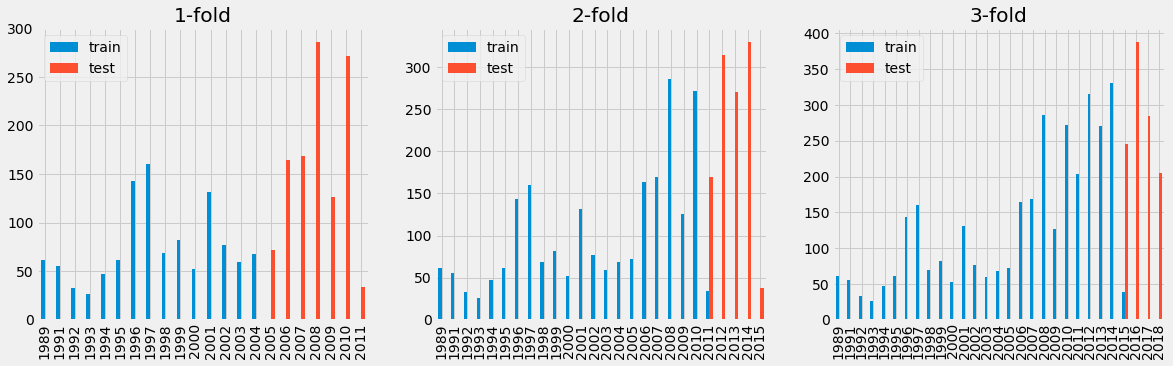

In [36]:
train_time, test_time = naive_timesplit_CV(model_RF, compounds_set_time, n_folds=3, get_sets=True)
plot_cv_data(train_time, test_time, 3, 'Data selection in time-split CV (naive)')


Data selection in time-split CV (split by years)


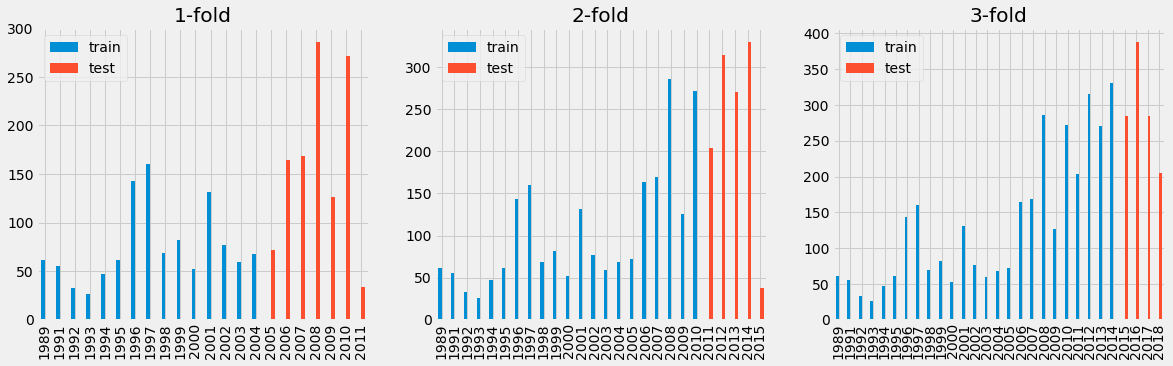

In [37]:
train_time, test_time = timesplit_CV(model_RF, compounds_set_time, n_folds=3, get_sets=True)
plot_cv_data(train_time, test_time, 3, 'Data selection in time-split CV (split by years)')

Accuracy of Cross Validation methods per fold.

Accuracy per fold


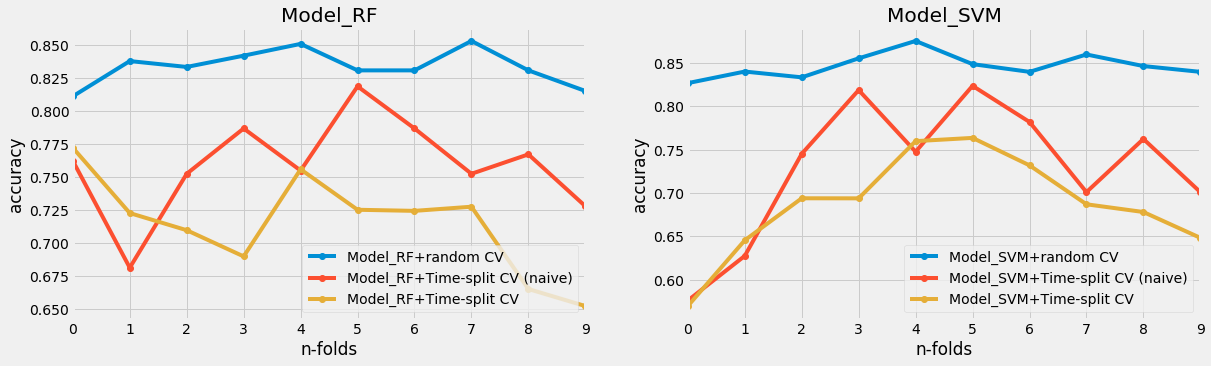

In [38]:
plot_cv_accuracy(models_acc, models_method, 'Accuracy per fold')

In time-split CV, the data is partitioned relative to the number of folds.


* The performance on random split is much better than for time series splits, which seems compared to the others to be very optimistic.
* In random CV the data samples are shuffled and thus more homogenously distributed.
* More structural diverse molecules were published at a specific year.

A large difference in the performance of both time-based splitting methods could indicate:
* Split ratio in train and test set was nearly 50% (if number of samples in test set is low, it is crucial for the predictive performance).

#### 5.2 Single Random vs. Cluster-based Split

Since it is not guaranteed that both clustering methods will generate the same test size, the main aim was to set the cut-off for Butina Clustering and the number of cluster centers for K-means such that the train/test split ratio is as close as possible for this data set. 

This resulted in test sizes of
* 22.01% for Butina clustering
* 22% for random single split
* 19.99% for K-means clustering

the maximal deviation between the sets is therefore 2.2%.

RF Butina Clustering  RF K-means Clustering  RF static Clustering
accuracy                 0.757331               0.796214              0.806876
sensitivity              0.882474               0.866667              0.883598
specificity              0.636905               0.630597              0.703791
auc                      0.859311               0.823848              0.885579

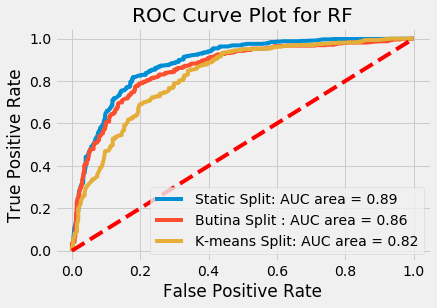

In [39]:
plot_roc_curves_for_singlemodel([static_models[0], butina_models[0], kmeans_models[0]], 
                                [static_xtest, butina_xtest, kmeans_xtest], 
                                [static_ytest, butina_ytest, kmeans_ytest], 
                                ['Static Split','Butina Split ','K-means Split'],
                                'ROC Curve Plot for RF');
df_results_RF

Based on the prior results it is to be expected that the random split shows for both RF and SVM the best performance. 

* Accuracy of the models is higher for K-means clustering: The sum of the True Postivies and True Negatives (correct predictions) is therefore higher.
* AUC value of the models is higher for Butina clustering: The higher auc value indicates that the models tend to better differentiate the samples of the two classes.


SVM Butina Clustering  SVM K-means Clustering  \
accuracy                  0.771486                0.821826   
sensitivity               0.876289                0.906349   
specificity               0.670635                0.623134   
auc                       0.847552                0.825080   

             SVM static Clustering  
accuracy                  0.822042  
sensitivity               0.906526  
specificity               0.708531  
auc                       0.881272

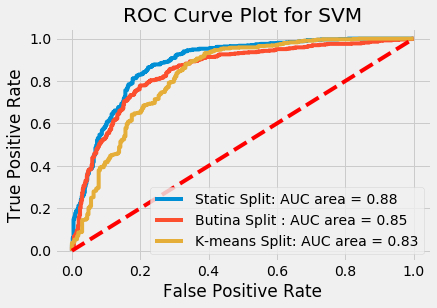

In [40]:
plot_roc_curves_for_singlemodel([static_models[1], butina_models[1], kmeans_models[1]], 
                                [static_xtest, butina_xtest, kmeans_xtest], 
                                [static_ytest, butina_ytest, kmeans_ytest], 
                                ['Static Split','Butina Split ','K-means Split'],
                                'ROC Curve Plot for SVM');
df_results_SVM

#### 5.3 Visualization of cluster and molecule distribution

Number of clusters: 1710 from 4493 molecules at distance cut-off 0.10
Number of molecules in largest cluster: 52
Similarity between two random points in same cluster: 0.91
Similarity between tfwo random points in different cluster: 0.64


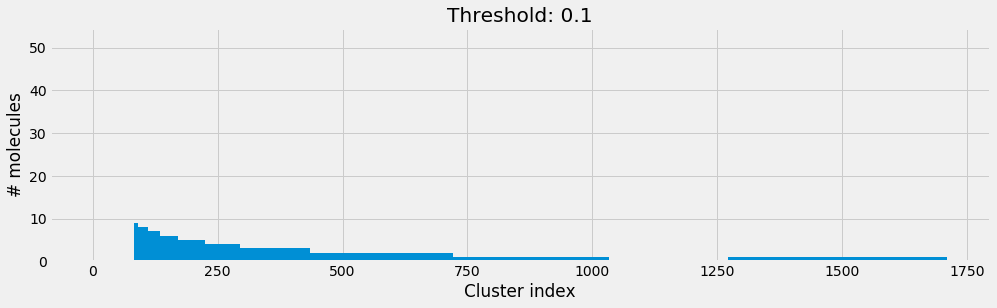

In [41]:
# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cut_off:3.1f}")

print(f"Number of clusters: {len(clusters)} from {len(compound_df)} molecules at distance cut-off {cut_off:.2f}")
print("Number of molecules in largest cluster:", len(clusters[0]))
print(f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(df_fingerprints[clusters[0][0]], df_fingerprints[clusters[0][1]]):.2f}")
print(f"Similarity between tfwo random points in different cluster: {DataStructs.TanimotoSimilarity(df_fingerprints[clusters[0][0]], df_fingerprints[clusters[1][0]]):.2f}")

Distrubution of the clusters is flat and the molecules are quite homogenuous distributed, in contrast to the clusters created with k-means.

Number of clusters: 31 from 4493 molecules.
Number of molecules in largest cluster: 3484
Similarity between two random points in same cluster: 0.74
Similarity between two random points in different cluster: 0.30


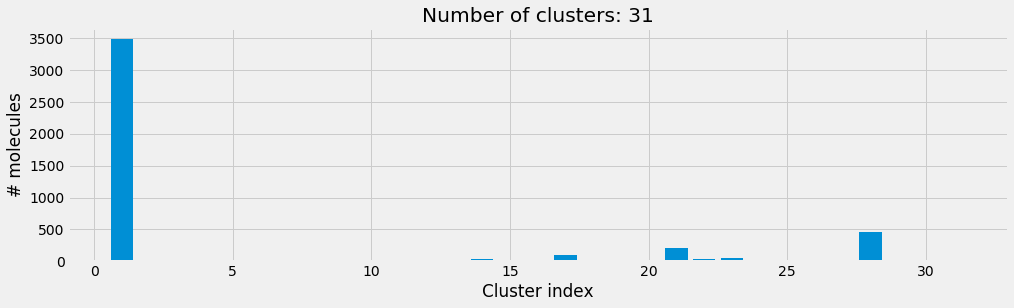

In [42]:
# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(features) + 1), [len(f) for f in features])
ax.set_title(f"Number of clusters: {num_clusters}")

print(f"Number of clusters: {len(features)} from {len(compound_df)} molecules.")
print("Number of molecules in largest cluster:", len(features[0]))
print(f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(df_fingerprints[features[0][0]], df_fingerprints[features[0][1]]):.2f}")
print(f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(df_fingerprints[features[0][0]], df_fingerprints[features[1][0]]):.2f}")

K-means tend to create one large cluster for this data. The number of clusters is lower and the size of the largest cluster is twice as large compared to butina. Accordingly, the similarity between the molecules within a cluster is lower with 74% compared to butina with 91% and difference between two random molecules from the clusters as well (30% vs. 64%).

Ten molecules from largest cluster:


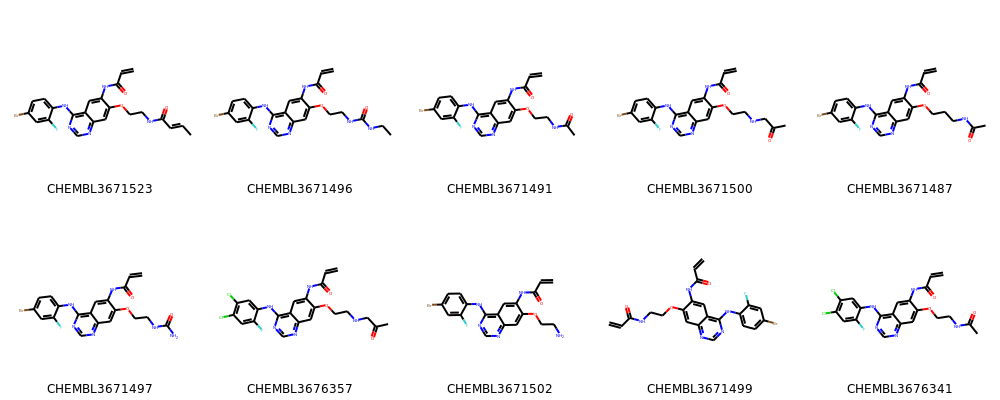

In [43]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(compound_df.smiles[i]) for i in clusters[0][:10]],
    legends=[compound_df.molecule_chembl_id[i] for i in clusters[0][:10]],
    molsPerRow=5,
)

Ten molecules from largest cluster:


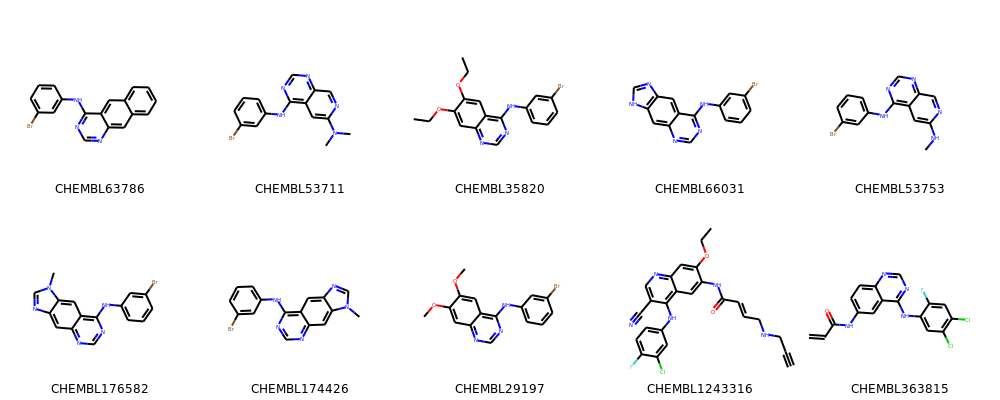

In [44]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(compound_df.smiles[i]) for i in features[0][:10]],
    legends=[compound_df.molecule_chembl_id[i] for i in features[0][:10]],
    molsPerRow=5,
)

The similarity between the molecules within a cluster is lower in case of K-means. Since for both clutser methods, the largest cluster was used as training set, it is to be expected that the mocules in K-means cover a wider chemical space and thus lead to a better accuracy.